# <a id='toc1_'></a>[Hull-White Model](#toc0_)
Utilizing Current Market Data to Predict 60-Day Forward Interest Rate Paths

**Disclosure**: I utitlized **ChatGPT V4.0** for English writting refinments and **Github's Copilot** for function and class documentations defined in `src` directory. 

**Table of contents**<a id='toc0_'></a>    
- [Hull-White Model](#toc1_)    
  - [Theory](#toc1_1_)    
    - [Interest Rate Models](#toc1_1_1_)    
    - [Hull-White Model](#toc1_1_2_)    
  - [Implementation](#toc1_2_)    
  - [Discussion](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Theory](#toc0_)

### <a id='toc1_1_1_'></a>[Interest Rate Models](#toc0_)
Interest rate models are essential tools for pricing financial derivatives and managing financial risk. They are broadly classified into two types:

- **Equilibrium Models**: Vasicek and Cox-Ingersoll-Ross (CIR) models belong to this category. They are mean-reverting models that ensure interest rates remain positive but often fail to match the initial term structure of interest rates.

- **No-Arbitrage Models**: These models, including Ho-Lee, Black-Derman-Toy (BDT), and Hull-White models, focus on fitting the initial term structure and ruling out arbitrage opportunities.

### <a id='toc1_1_2_'></a>[Hull-White Model](#toc0_)
The Hull-White model improves on the aforementioned models by incorporating time-dependent volatility, leading to enhanced flexibility. The model is defined by the stochastic differential equation:

$dr(t) = [θ(t) - a(t) * r(t)] * dt + σ(t) * dW(t)$

Where:

- **$r(t)$**: The short rate
- **$θ(t)$**: A deterministic function of time
- **$a(t)$**: The mean-reversion level
- **$σ(t)$**: The volatility
- **$dW(t)$**: A Wiener process representing market risk

The inclusion of a time-dependent mean reversion and volatility allows the Hull-White model to effectively price interest rate derivatives, especially those sensitive to the term structure of interest rates like bonds.

Next, we will use current market data for parameter estimation in the Hull-White model and simulate different potential paths for 60-day forward interest rates.

## <a id='toc1_2_'></a>[Implementation](#toc0_)

The data for zero-coupon bonds was sourced from *Farabourse*, which was subsequently saved in an Excel spreadsheet titled bonds.xlsx located within the data directory. Post-processing involved filtering out bonds that have not reached maturity. Displayed below are the first five records from this curated dataframe:

In [1]:
import numpy as np
from src.data import read_bonds
df = read_bonds()
df.head(5)

,price,maturity,ytm
0,740880,1.347945,0.2456
1,714400,1.520548,0.2465
2,802390,1.002740,0.2420
3,784510,1.098630,0.2450
4,766970,1.194521,0.2468


The HullWhite class in the src.Interest module encapsulates three core functionalities which are instrumental to the implementation of the Hull-White model. Below is a breakdown of the component functions:

| Function | Description | Role |
| -------- | ----------- | ---- |
| `objective` | Defines the Hull-White model equation | Utilized in minimization process via `least_squares` function from the SciPy package |
| `generate_paths` | Generates multiple potential paths based on the stochastic Hull-White model | Employs the defined parameters to generate diverse future scenarios |
| `plot_paths` | Visualizes the generated paths | Creates intuitive plots to depict potential future trajectories of interest rates |

In [22]:
from src.Interest import HullWhite as HW

# initial guess for a, sigma
x0 = np.array([0.01, 0.01])
args = (df['price'].values, df['maturity'].values, df['ytm'].values)

# minimizing the objective function
from scipy.optimize import least_squares
result = least_squares(HW.objective, x0, args=args)

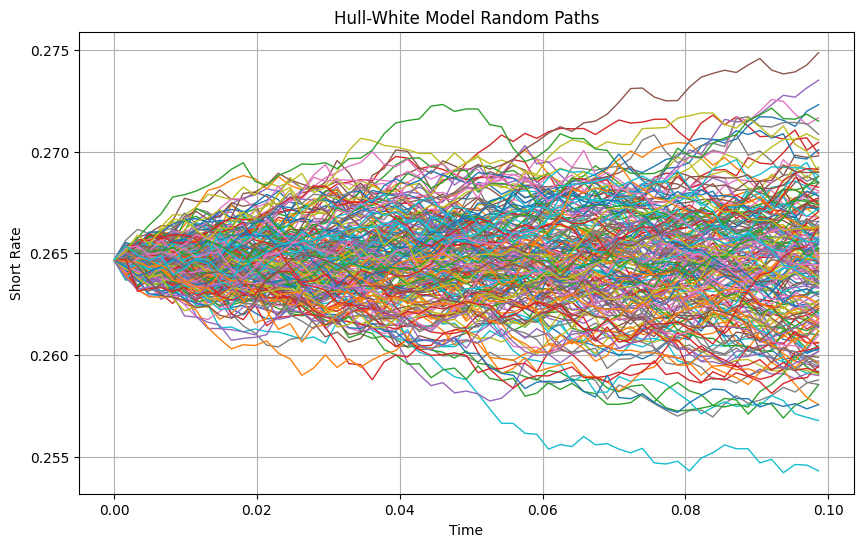

In [31]:
# get estimated parameters
estimated_mean_reversion, estimated_volatility = result.x
initial_rate = df.sort_values(by='maturity')[:6].ytm.mean()

# plot model results
maturity = 60/365
num_paths=200
num_steps=100
paths = HW.generate_paths(estimated_mean_reversion, estimated_volatility, initial_rate, maturity, num_paths, num_steps)
HW.plot_paths(paths, num_steps, maturity)

## <a id='toc1_3_'></a>[Discussion](#toc0_)


The calibration of the Hull-White model to the market data resulted in the parameters $a=0.0240971$ and $\sigma=0.01112777$.



The mean-reversion speed parameter, $a$, represents how quickly the interest rate reverts towards its long-term mean level. A lower value of $a$ signifies that the interest rate is less responsive to changes, taking longer to revert to the mean, while a higher value indicates a faster reversion. Our estimate of $a$ is relatively low, suggesting that in our model, interest rates tend to revert slowly to their long-term average.

The volatility parameter, $\sigma$, controls the standard deviation of the changes in the interest rate. In our case, the estimated $\sigma$ is quite small. This implies that our model predicts relatively small daily variations in interest rates.



For the initial interest rate, the mean yield to maturity of the first six bonds with the lowest maturities was used. The rationale behind this choice is based on the concept that these bonds with the shortest maturities will be most reflective of the 'current' interest rate. Given that these bonds are the closest to maturity, they will be the least sensitive to interest rate changes, hence providing a more reliable and stable estimate for the initial rate, which in our case is $0.264666$.



Next, the model was used to simulate 200 paths for forward interest rates over a 60-day period. The resulting plot presents a variety of potential scenarios for the evolution of interest rates, reflecting the inherent randomness in their future values. This randomness is influenced by the estimated mean-reversion speed and volatility parameters.



Despite the stochastic nature of these simulations, certain trends may be discernible due to the mean-reverting nature of the Hull-White model. However, it's essential to remember that these simulations are based on the estimated parameters, which themselves are derived from historical data. Therefore, they may not perfectly forecast future interest rate movements.


In conclusion, the Hull-White model provides a useful framework for understanding and simulating the dynamics of interest rates. However, like any model, it simplifies reality and comes with certain assumptions and limitations. It's crucial to understand these aspects when interpreting the results.

Given the parameters $a=0.0240971$ and $\sigma=0.01112777$, and the initial short rate $r(0)=0.26466$, the Hull-White one-factor model formula becomes:

$$
dr(t) = a(\theta(t) - r(t))dt + \sigma dW(t)
$$


where $a = 0.0240971$ and $\sigma = 0.01112777$ are the estimated parameters, $W(t)$ is a Wiener process, and $\theta(t)$ is a time-dependent function that is fitted using market data.

The integral form (or the solution to the stochastic differential equation) is given by:

$$
r(t) = r(0)e^{-at} + \theta(t)(1-e^{-at}) + \sigma \int_0^t e^{a(s-t)}dW(s)
$$